In [37]:
%matplotlib inline

import gym
import matplotlib
import numpy as np
import sys

from collections import defaultdict
if "../" not in sys.path:
  sys.path.append("../") 
from lib.envs.blackjack import BlackjackEnv
from lib import plotting

matplotlib.style.use('ggplot')

In [38]:
env = BlackjackEnv()

In [39]:
def create_random_policy(nA):
    """
    Creates a random policy function.
    
    Args:
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes an observation as input and returns a vector
        of action probabilities
    """
    A = np.ones(nA, dtype=float) / nA
    def policy_fn(observation):
        return A
    return policy_fn

In [40]:
def create_greedy_policy(Q):
    """
    Creates a greedy policy based on Q values.
    
    Args:
        Q: A dictionary that maps from state -> action values
        
    Returns:
        A function that takes an observation as input and returns a vector
        of action probabilities.
    """
    
    def policy_fn(observation):
        nA = len(Q[observation])
        best_action = np.argmax(Q[observation])
        probs = np.zeros([nA])
        probs[best_action] = 1
        return probs
    return policy_fn

In [45]:
def mc_control_importance_sampling(env, num_episodes, behavior_policy, discount_factor=1.0):
    """
    Monte Carlo Control Off-Policy Control using Weighted Importance Sampling.
    Finds an optimal greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Nubmer of episodes to sample.
        behavior_policy: The behavior to follow while generating episodes.
            A function that given an observation returns a vector of probabilities for each action.
        discount_factor: Lambda discount factor.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities. This is the optimal greedy policy.
    """
    
    def return_following_state(episode, discount_factor=discount_factor):
        """returns the total discounted reward in the sequence, sums over the list of the mapping of a *dicount_factor**step"""
        rewards = np.array([episode_tuple[2] for episode_tuple in episode])
        discounted_rewards = list(map(lambda index, reward: reward * (discount_factor**index) ,range(len(rewards)) ,rewards))
        return np.sum(discounted_rewards)
    
    def trajectory_probability(episode, policy):
        visited_states = [episode_tuple[0] for episode_tuple in episode]
        taken_actions = [episode_tuple[1] for episode_tuple in episode]
        return np.product([policy(state)[action] for state,action in zip(visited_states,taken_actions)])

    
    # The final action-value function.
    # A dictionary that maps state -> action values
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # Our greedily policy we want to learn
    target_policy = create_greedy_policy(Q)
    
    # Implement this!
    
    
    for i_episode in range(num_episodes):
        if((i_episode + 1) % 10000 == 0):
            print("Currently in episode: {i_episode}".format(i_episode = i_episode +1), end="")
            sys.stdout.flush()
        #generate an episode
        episode = []
        state = env.reset()
        done = False
        while not done:
            action = np.random.choice(a=list(range(env.nA)), p=behavior_policy(state))
            new_state , reward, done, _ = env.step(action)
            episode.append((state, action, reward, new_state))
            state = new_state  
        
        state_action_pairs = [(episode_tuple[0],episode_tuple[1]) for episode_tuple in episode]
    
    
    
        for index, (state, action) in enumerate(state_action_pairs):
            target_prob = trajectory_probability(episode[index:], target_policy)
            behavioral_prob = trajectory_probability(episode[index:], behavior_policy)
            importance_sampling_ratio =  target_prob / behavioral_prob
            returns_count[(state,action)] += 1 * importance_sampling_ratio
            returns_sum[(state,action)] += return_following_state(episode[index:]) * importance_sampling_ratio
            Q[state][action] = returns_sum[(state,action)] / returns_count[(state,action)]




        #update the policy according to the new q values
        target_policy = create_greedy_policy(Q)
    
    
        
    return Q, target_policy

In [46]:
random_policy = create_random_policy(env.action_space.n)
Q, policy = mc_control_importance_sampling(env, num_episodes=500000, behavior_policy=random_policy)

Currently in episode: 10000Currently in episode: 20000Currently in episode: 30000Currently in episode: 40000Currently in episode: 50000Currently in episode: 60000Currently in episode: 70000Currently in episode: 80000Currently in episode: 90000Currently in episode: 100000Currently in episode: 110000Currently in episode: 120000Currently in episode: 130000Currently in episode: 140000Currently in episode: 150000Currently in episode: 160000Currently in episode: 170000Currently in episode: 180000Currently in episode: 190000Currently in episode: 200000Currently in episode: 210000Currently in episode: 220000Currently in episode: 230000Currently in episode: 240000Currently in episode: 250000Currently in episode: 260000Currently in episode: 270000Currently in episode: 280000Currently in episode: 290000Currently in episode: 300000Currently in episode: 310000Currently in episode: 320000Currently in episode: 330000Currently in episode: 340000Currently in episode: 350000Currently in episode: 360000C

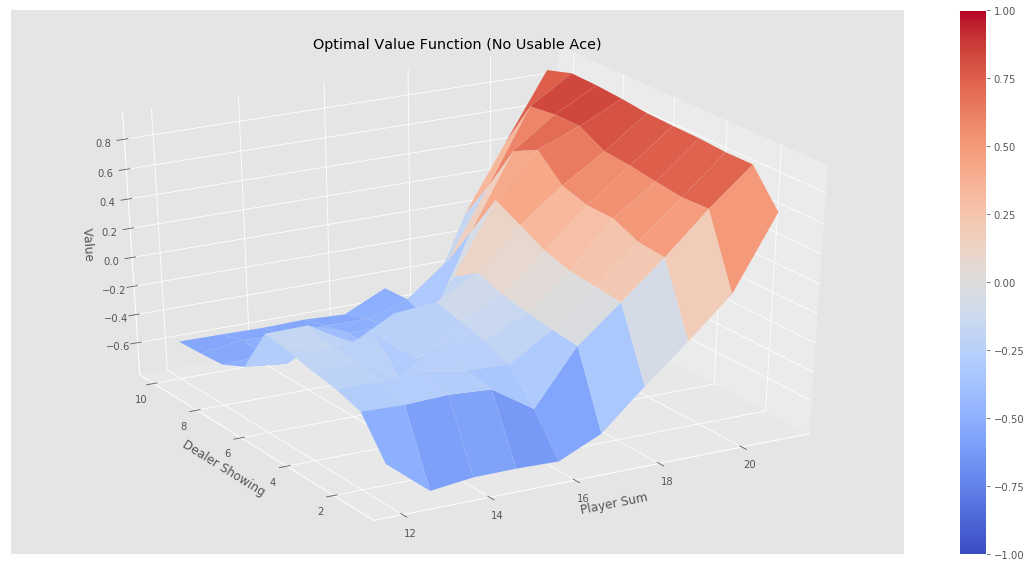

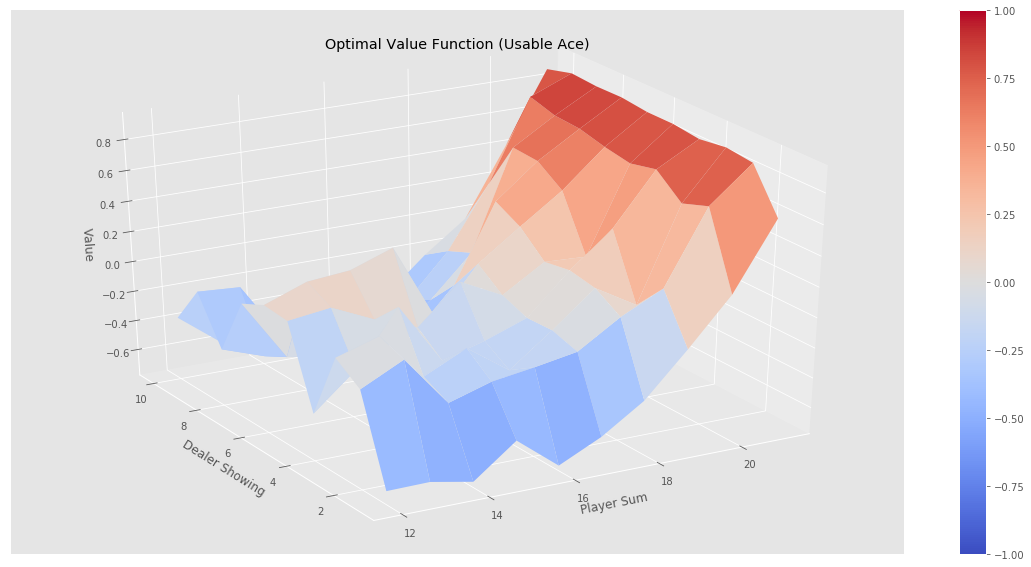

In [47]:
# For plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)
for state, action_values in Q.items():
    action_value = np.max(action_values)
    V[state] = action_value
plotting.plot_value_function(V, title="Optimal Value Function")